In [228]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve

In [229]:
# Physical Parameters
G       = 6.67430e-11       # m^3 / (kg s^2)
c       = 2.99792458e8      # m / s
Msun    = 1.98847e30        # kg

L_scale = G * Msun / c**2   # 1477 m
M_scale = Msun              # 2e30 kg

# Density scale for dimensionless -> SI
rho_scale = Msun / (L_scale**3)


In [230]:
def tov_equations(r, y, K_NS):
        # This function defines and returns the TOV equations 
        # Parameters: r : dimensionless radius,  y: [m, p, nu], K_NS: polytropic constant (dimensionless), m_p: baryonic mass
    
        m, p, nu, m_p = y
        
        # If pressure is negative, derivatives should vanish since we're not on the star
        if p <= 0:
            return [0.0, 0.0, 0.0, 0.0]
        
        # EOS
        rho = np.sqrt(p / K_NS)

        
        # TOV equations
        dm_dr = 4.0 * np.pi * r**2 * rho
        
        # Avoid singularities at r = 0
        if r < 1e-12:
            dnu_dr = 0.0
            dp_dr  = 0.0
        else:
            denom  = r * (r - 2.0 * m)
            dnu_dr = 2.0 * (m + 4.0 * np.pi * r**3 * p) / denom
            dp_dr  = -(m + 4.0 * np.pi * r**3 * p) * (rho + p) / denom
            dmp_dr = 4*np.pi * r**2 * rho / np.sqrt(1 - 2*m/r)

        
        return [dm_dr, dp_dr, dnu_dr, dmp_dr]

In [231]:
def solve_tov(K_NS, p_c, r_max=20.0):
        # Solves TOV equations in dimensionless form up to r=r_max or until p(r)-> 0. 
        # Returns the final radius and mass in dimensionless units,plus the radial solution arrays if desired.

        # Initial conditions at r=0
        m0  = 0.0
        p0  = p_c
        nu0 = 0.0
        m_p0 = 0.0
        y0  = [m0, p0, nu0, m_p0]
        
        # Stop integration when p=0
        def stop_condition(rr, yy):
            return yy[1]  # p(r)
        stop_condition.terminal   = True
        stop_condition.direction  = -1  # we expect p to decrease
        
        sol_ivp = solve_ivp(fun=lambda rr, yy: tov_equations(rr, yy, K_NS),t_span=(1e-9, r_max),  y0=y0,events=stop_condition, max_step=1e-3, dense_output=True)
        
        # If p hits zero early, we reached star boundary there
        if sol_ivp.t_events[0].size > 0:
            r_star = sol_ivp.t_events[0][0]  # dimensionless R
        else:
            r_star = r_max  # if did not go to zero within r_max
        
        r_vals = np.linspace(0, r_star, 400)
        sol    = sol_ivp.sol(r_vals)

        return r_vals, sol

In [232]:
def get_max_mass(K, rho_c_array):
    # This method solves TOV for each central density and returns the maximum mass in units of Solar Mass
    masses = []
    for rho_c in rho_c_array:
        p_c = K * rho_c**2  
        r_vals, sol = solve_tov(K, p_c)
        M_dimless   = sol[0][-1]  # final mass from TOV
        M_solar     = M_dimless   
        masses.append(M_solar)
    
    M_max = np.max(masses)
    return M_max

In [233]:
    def part_ab(K_NS, p_c_list):
        # Solves part a of Einstein. Solves TOV for each central pressure and returns arrays for plotting

        R_vals_SI = []
        M_vals_SI = []

        R_vals_km = []
        M_vals_sol = []

        Delta_list = []
        
        for p_c in p_c_list:
            r_vals, sol = solve_tov(K_NS, p_c)
            m_of_r = sol[0]  # dimensionless mass
            # The final point is the star's surface
            R_dimless = r_vals[-1]
            M_dimless = m_of_r[-1]

            M  = sol[0][-1]
            Mp = sol[3][-1]
            Delta = (Mp - M)/M
            
            Delta_list.append(Delta)
            
            R_SI = R_dimless * L_scale  # SI units
            M_SI = M_dimless * M_scale
            
            R_vals_SI.append(R_SI)
            M_vals_SI.append(M_SI)

            R_vals_km.append(R_dimless * (G * Msun / c**2) / 1e3)
            M_vals_sol.append(M_dimless)

    
        
        return np.array(R_vals_SI), np.array(M_vals_SI), np.array(R_vals_km), np.array(M_vals_sol), np.array(Delta_list)

In [234]:
def part_c(K_NS, rho_c_array):
    # Solves part C by taking numerical derivative of dM_drho
    M_list = []
    for rho_c in rho_c_array:
        p_c = K_NS * rho_c**2
        
        # Solve TOV 
        r_vals, sol = solve_tov(K_NS, p_c)
        M_dimless = sol[0][-1]
        
        # Convert to M_sun
        M_solar = M_dimless 
        M_list.append(M_solar)
    

    M_list = np.array(M_list)
    rho_c_array = np.array(rho_c_array)
    
    # Numerical derivative
    dM_drho = np.gradient(M_list, rho_c_array)
    
    # stable if dM_drho > 0
    # unstable if dM_drho < 0
    
    return rho_c_array, M_list, dM_drho

####################### PART A #########################


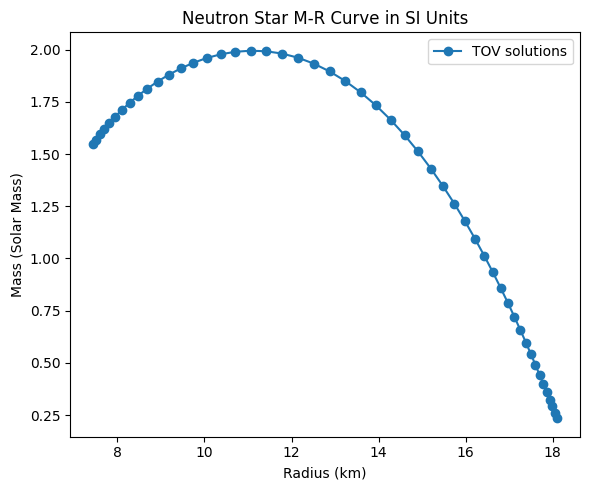

####################### PART B #########################


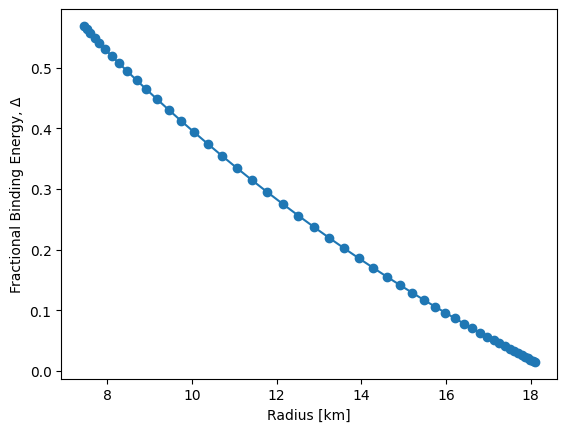

####################### PART C #########################


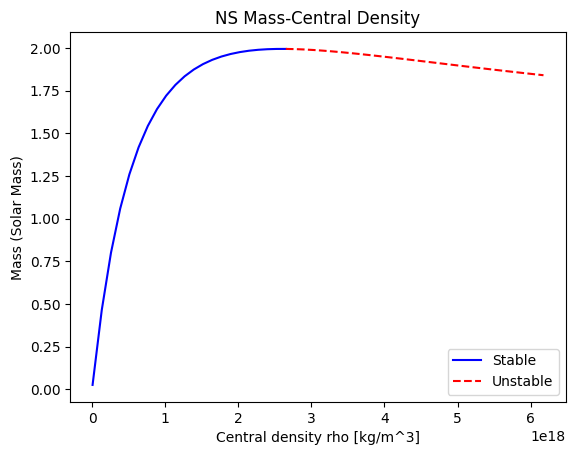

Maximum mass = 1.995 Msun at rho_c = 2.65e+18 [kg/m^3]
####################### PART D #########################
K that yields 2.14 Msun: 115.03738042685654


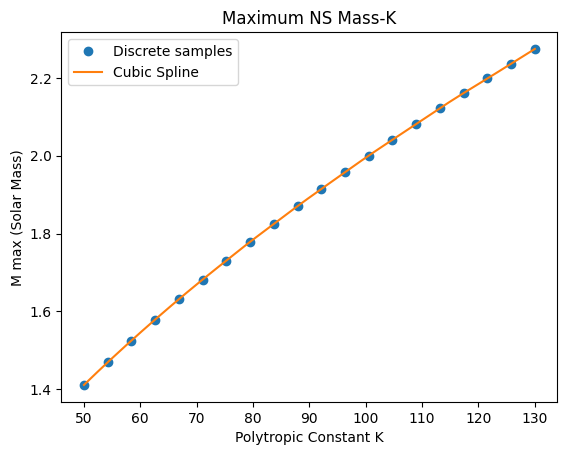

In [235]:
def my_tests_einstein():
    # Main function that solves all parts of the Einstein


    ####################### PART A #########################
    print('####################### PART A #########################')

    K_NS = 100
    N_samples = 50
    
    # Range of central pressures
    p_c_list = np.logspace(-6, -1, N_samples)  

    
    # Solve TOV for each central pressure
    R_vals_SI, M_vals_SI, R_km, M_solar, Delta_list = part_ab(K_NS, p_c_list)
    
    # Plot M vs R in SI units
    plt.figure(figsize=(6,5))
    plt.plot(R_km, M_solar, 'o-', label='TOV solutions')
    plt.xlabel('Radius (km)')
    plt.ylabel('Mass (Solar Mass)')
    plt.title('Neutron Star M-R Curve in SI Units')
    plt.legend()
    plt.tight_layout()
    plt.show()



    ####################### PART B #########################
    print('####################### PART B #########################')

    plt.plot(R_km, Delta_list, 'o-')
    plt.xlabel('Radius [km]')
    plt.ylabel('Fractional Binding Energy, Δ')
    plt.show()




    ####################### PART C #########################
    print('####################### PART C #########################')

    rho_c_span = np.linspace(10**-5, 10**-2, N_samples) 
    
    rho_c, M_vals, dM_drho = part_c(K_NS, rho_c_span)
    
    rho_c_SI = rho_c * rho_scale

    
    imax = np.argmax(M_vals)
    plt.plot(rho_c_SI[:imax+1], M_vals[:imax+1], 'b-', label='Stable')
    plt.plot(rho_c_SI[imax:],   M_vals[imax:],   'r--', label='Unstable')
    plt.xlabel('Central density rho [kg/m^3]')
    plt.ylabel('Mass (Solar Mass)')
    plt.legend()
    plt.title('NS Mass-Central Density')
    plt.show()

    imax = np.argmax(M_vals) # Maximum mass
    print("Maximum mass = %.3f Msun at rho_c = %.2e [kg/m^3]" 
          % (M_vals[imax], rho_c_SI[imax]))
    


    ####################### PART D #########################
    print('####################### PART D #########################')
    

    N_sample = 20
    k_range =  np.linspace(50, 130, N_sample)  
    

    rho_c_span = np.linspace(10**-5, 10**-2, N_sample)
    
    M_max_list = []
    for K in k_range:
        Mmax = get_max_mass(K, rho_c_span)
        M_max_list.append(Mmax)
    

    k_range   = np.array(k_range)
    M_max_list = np.array(M_max_list)

    # Fit a cubic spline to the pairs
    cs = CubicSpline(k_range, M_max_list)

    def fun_for_fsolve(K):
        return cs(K) - 2.14
    
    K_solution = fsolve(fun_for_fsolve, x0=100.0)   # Initial guess 100
    print("K that yields 2.14 Msun:", K_solution[0])

    K_dense = np.linspace(50, 130, 300)
    M_spline_dense = cs(K_dense)   

    # Plot discrete data 
    plt.plot(k_range, M_max_list, 'o', label='Discrete samples')
    # Plot the spline
    plt.plot(K_dense, M_spline_dense, '-', label='Cubic Spline')
    plt.xlabel('Polytropic Constant K')
    plt.ylabel('M max (Solar Mass)')
    plt.title('Maximum NS Mass-K')
    plt.legend()
    plt.show()
 

if __name__ == "__main__":
    my_tests_einstein()